# Modeling with Lemmatized Words
In this notebook I plan to run the same models as the previous notebook, with the exception of lemmatizing the words prior to vectorizing and modeling. This will take the words to a more meaningful base form, and therefore have less words for the models to place. without lemmatizing I may have words like dance, dancing, danced, dances, after lemmatizing all these words would fall under dance.

#### Table of Contents
<br>`Pre-Processing`</br>

- [Baseline & Target](#target)
- [Pipeline & GridSearch Function](#pipe)

<br>`Modeling`</br>

- [MultinomialNB](#Mnb)
- [BernoulliNB](#Bnb)
- [Ada Boost](#ada)

<br>`Conclusion`</br>

- [TLDR](#conc)    

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text # to add more stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, f1_score, recall_score

from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from nltk.stem import WordNetLemmatizer 

In [2]:
df = pd.read_csv('./data/lyrics_cleaned.csv')

### Baseline Score<a id='target'></a>

In [3]:
df["skip"].value_counts(normalize=True)

0    0.75993
1    0.24007
Name: skip, dtype: float64

### Pre-Processing

There are some words that I don't want displayed on screen so I will replace them as 'vulgar', they can still help my model with it's predictions. These words are not so much easy predictors, as much as they are words that I don't feel comfortable being part of my visualizations or my publicly viewable project.

In [4]:
some_words = open("./data/drop_words.txt").read().split()

for i in some_words:   
    df['lyrics'] = df['lyrics'].str.lower().str.replace(rf"\b{i}\b", 'vulgar')

To lemmatize my words, I first have to iterate through each value in the row if the lyrics column, then I have to split the values into separate words and lemmatize them. In the process the string in the column because a list of the words, I then need to reiterate through the values in the column and rejoin the list to be one string, so that they can be split apart correctly in the vectorizer in the pipeline
<br>Let's see what the lyrics look like prior to lemmatizing:</br>

In [5]:
before = df['lyrics'][0]
before

'drank young money   love in a thousand different flavors i wish that i could taste them all tonight no, i aint got no dinner plans so you should bring all your friends i swear that a-all yall my type   all you girls in here, if youre feeling thirsty come on take a sip cause you know what im servin, ooh   shimmy shimmy yay, shimmy yay, shimmy ya (drank) swalla-la-la (drank) swalla-la-la (swalla-la-la) swalla-la-la shimmy shimmy yay, shimmy yay, shimmy ya (drank) swalla-la-la (drank) swalla-la-la (swalla-la-la) swalla-la-la freaky, freaky gyal my freaky, freaky gyal   shimmy shimmy shimmy yay, shimmy yah bad girls gon swalla-la-la bust down on my wrist in this bitch my pinky-ring bigger than his met her out in beverly hills, ay dolla got too many girls, ay met her out in beverly hills all she wear is red bottom heels when she back it up, put it on the snap when she droppin low, put it on the gram dj poppin, she gon swallow that champagne poppin, she gon swallow that   all you girls in h

In [6]:
lemmatizer = WordNetLemmatizer() #instantiate model
df['lyrics'] = df['lyrics'].map(lambda x: [lemmatizer.lemmatize(word) for word in x.split()]) # for each row in the lyrics column, split the words and lemmatize
df['lyrics'] =  df['lyrics'].map(lambda x: ' '.join(x)) # for each row in the lyrics column rejoin the individual words

In [7]:
after = df['lyrics'][0]
after

'drank young money love in a thousand different flavor i wish that i could taste them all tonight no, i aint got no dinner plan so you should bring all your friend i swear that a-all yall my type all you girl in here, if youre feeling thirsty come on take a sip cause you know what im servin, ooh shimmy shimmy yay, shimmy yay, shimmy ya (drank) swalla-la-la (drank) swalla-la-la (swalla-la-la) swalla-la-la shimmy shimmy yay, shimmy yay, shimmy ya (drank) swalla-la-la (drank) swalla-la-la (swalla-la-la) swalla-la-la freaky, freaky gyal my freaky, freaky gyal shimmy shimmy shimmy yay, shimmy yah bad girl gon swalla-la-la bust down on my wrist in this bitch my pinky-ring bigger than his met her out in beverly hills, ay dolla got too many girls, ay met her out in beverly hill all she wear is red bottom heel when she back it up, put it on the snap when she droppin low, put it on the gram dj poppin, she gon swallow that champagne poppin, she gon swallow that all you girl in here, if youre feel

After Lemmatizing the lyrics look similar there are some minor changes in this specific song, I'll iterate through the words in the before lemmatize and pull out the words that are no longer in the after lemmatize:

In [8]:
for word in before.split():
    if word not in after:
        print(word)

flavors
plans
friends
heels
wins
blimps
minks
chimps
bitches
times
shots
sucks
guts
nuts


In this case the lematizer just removed the pluralization of these words, in other lyrics it removes past tense, active etc.

### Train Test Split
Same as the last set of models, X will be the lyrics and y (target) is the Skip classes


In [9]:
X = df['lyrics']
y = df['skip']

In [10]:
# since the categories are unbalanced I will stratify y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y) 
# Check shapes of the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8591,), (2864,), (8591,), (2864,))

## TLDR:<a id='conc'></a>
<b>All the models here scored slightly lower than the models in the first notebook, may have to re-tweak the word lemmatizer</b>

### Pipeline Fucntion<a id='pipe'></a>

In [11]:
def start_pipeline(vect, model, color, pipe_params): # takes type of vectorizer, model, color of confusion matrix, and pipe params
    
    # Types of Vectorizers
    if vect == 'cv':
        instantiate_vect = CountVectorizer
        vect_name = 'CountVectorizer'
    elif vect == 'tvec':
        instantiate_vect = TfidfVectorizer
        vect_name = 'TfidfVectorizer'
        
      # Types of Models  
    if model == 'Mnb':
        instantiate_model = MultinomialNB
        model_name = 'MultinomialNB'
    elif model == 'Bnb':
        instantiate_model = BernoulliNB
        model_name = 'BernoulliNB'
    elif model == 'lg':
        instantiate_model = LogisticRegression
        model_name = 'LogisticRegression'
    elif model == 'ada':
        instantiate_model = AdaBoostClassifier
        model_name = 'AdaBoostClassifier'     
    elif model == 'rdf':
        instantiate_model = RandomForestClassifier
        model_name = 'RandomForestClassifier'
          
        
        #----- Pipeline-----#
    
    pipe = Pipeline([
    (vect , instantiate_vect(stop_words = 'english')), # transformer
    (model , instantiate_model()) # estimator
    ])

    # --- Gridsearch----#
    gs = GridSearchCV(pipe,
                 pipe_params, # defined outside of function for easy change
                 cv=5,
                 verbose = 1,
                 n_jobs=-1)
    
    
    gs.fit(X_train,y_train) # fitting X_train and y_train
    preds = gs.predict(X_test) # predict test
    train_preds = gs.predict(X_train) # predict train
    
    #------ Scores & Params------- #
    print(f'Gridsearch best score is: {gs.best_score_}')
    print('')
    print(f'Gridsearch best params are: {gs.best_params_}')
    print('')
    print(f'{model_name} with {vect_name} Train Score :  {gs.score(X_train, y_train)*100:.2f}%')
    print(f'{model_name} with {vect_name}  Test Score  : {gs.score(X_test, y_test)*100:.2f}%')
    print('')
    print(f'{model_name} with {vect_name}  F1- Train Score: {f1_score(y_train, train_preds)}')
    print(f'{model_name} with {vect_name}  F1- Test Score:  {f1_score(y_test, preds)}')
    print('')
    
     # ----- Predictions ------ #
        
    print(f"{(precision_score(y_test, preds))*100:.2f}% of the words were predicted correctly by the model.")
    print(f"{(recall_score(y_test, preds))*100:.2f}% of the Skipped songs were found.")

    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print(f"The specificity is: {(tn / (tn + fp))*100:.2f}%")
    
    plot_confusion_matrix(gs, X_test, y_test, cmap= color);

In my note review of each upcoming model, I will make comparison notes to the first notebook, since the only thing that has changed between these two is the lemmatized words

### Multinomial Naive Bayes with Count Vectorizer<a id='Mnb'></a>

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  4.8min finished


Gridsearch best score is: 0.7891974988842769

Gridsearch best params are: {'cv__max_df': 0.5, 'cv__max_features': 5500, 'cv__min_df': 2, 'cv__ngram_range': (1, 1)}

MultinomialNB with CountVectorizer Train Score :  81.91%
MultinomialNB with CountVectorizer  Test Score  : 79.05%

MultinomialNB with CountVectorizer  F1- Train Score: 0.6537433155080214
MultinomialNB with CountVectorizer  F1- Test Score:  0.6036988110964332

55.33% of the words were predicted correctly by the model.
66.42% of the Skipped songs were found.
The specificity is: 83.04%


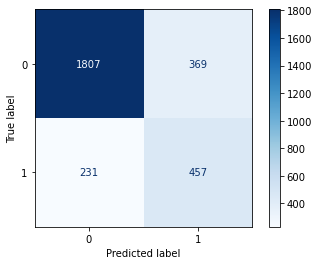

In [12]:
start_pipeline('cv', 'Mnb', 'Blues', pipe_params = {
                                'cv__max_features': [2_000, 4_500, 5_000, 5_500],
                                'cv__min_df' : [2,3], # ignore terms that show up less than 2 or 3 times in corpus
                                'cv__max_df' : [.5, .95], # ignore terms that show up either more than 50% or 95% of the corpus
                                'cv__ngram_range' : [(1,1), (1,2), (1,3)], # single words and bigrams
})

Slight Increase in overall scores however still overfit

### Multinomial Naive Bayes with TFIDF Vectorizer

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   34.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  4.9min finished


Gridsearch best score is: 0.8058442890897529

Gridsearch best params are: {'tvec__max_df': 0.5, 'tvec__max_features': 4000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 3)}

MultinomialNB with TfidfVectorizer Train Score :  82.24%
MultinomialNB with TfidfVectorizer  Test Score  : 80.55%

MultinomialNB with TfidfVectorizer  F1- Train Score: 0.5971488912354804
MultinomialNB with TfidfVectorizer  F1- Test Score:  0.5547561950439649

61.63% of the words were predicted correctly by the model.
50.44% of the Skipped songs were found.
The specificity is: 90.07%


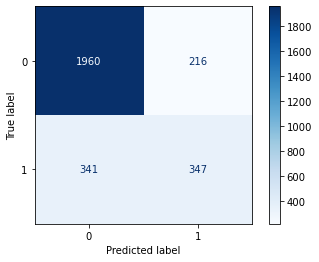

In [13]:

start_pipeline('tvec', 'Mnb', 'Blues', pipe_params = {
                                                        'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                        'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                        'tvec__min_df' : [2,3], 
                                                        'tvec__max_df' : [.5, .95]})

Again slightly better, scores have gotten closer to eachother compared to countvectorizer model and first notebook model, but still overfit

### Bernoulli Naive Bayes with Count Vectorizer<a id='Bnb'></a>

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 17.6min
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed: 29.5min finished


Gridsearch best score is: 0.7945530369675089

Gridsearch best params are: {'Bnb__alpha': 0.425, 'cv__max_df': 0.5, 'cv__max_features': 9000, 'cv__min_df': 3, 'cv__ngram_range': (1, 3)}

BernoulliNB with CountVectorizer Train Score :  80.19%
BernoulliNB with CountVectorizer  Test Score  : 79.68%

BernoulliNB with CountVectorizer  F1- Train Score: 0.6529363784665579
BernoulliNB with CountVectorizer  F1- Test Score:  0.6442542787286064

55.59% of the words were predicted correctly by the model.
76.60% of the Skipped songs were found.
The specificity is: 80.65%


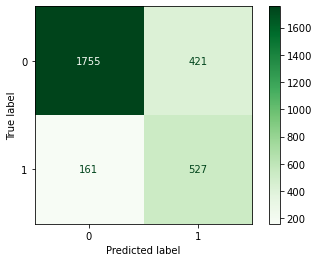

In [14]:
start_pipeline('cv', 'Bnb', 'Greens', pipe_params = {
                                                    'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                    'cv__max_features': [5_000, 5_500, 7_000, 9_000],
                                                    'cv__min_df' : [2,3],
                                                    'cv__max_df' : [.5, .95],
                                                    'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

Slight drop from first notebook

### Bernoulli Naive Bayes with TFIDF Vectorizer

In [ ]:
start_pipeline('tvec', 'Bnb', 'Greens', pipe_params = {
                                                'Bnb__alpha' : np.linspace(0.2,0.5,5),
                                                'tvec__max_features': [4_000, 5_000, 6_000, 7_000],
                                                'tvec__ngram_range': [(1,1), (1,2), (1,3)],
                                                'tvec__min_df' : [2,3], 
                                                'tvec__max_df' : [.5, .95],
})

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.9min


Better than countvectorizer, but still slightly less than the previous notebook. I do like the closeness is scores though

### Ada Boost with Count Vectorizer<a id='ada'></a>

In [ ]:
start_pipeline('cv', 'ada', 'Reds', pipe_params = {'cv__max_features': [5_000, 5_500, 9_000],
                                           'cv__min_df' : [2,3],
                                           'cv__max_df' : [.5, .95],
                                           'cv__ngram_range' : [(1,1), (1,2), (1,3)]})

Again, great closeness, minimal misclassification, however slightly lower than the first notebook. We've lost about 3% on precision

### Ada Boost with TFIDF Vectorizer

In [ ]:
start_pipeline('tvec', 'ada', 'Reds', pipe_params = {'tvec__max_features': [5_000, 5_500, 9_000],
                                           'tvec__min_df' : [2,3],
                                           'tvec__max_df' : [.5, .95],
                                           'tvec__ngram_range' : [(1,1), (1,2), (1,3)]})

Similar, better all around but lower than not lemmatizing